In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import colorsys

In [2]:
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority = 0):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.response_time = -1
        self.processed_time = 0
        self.priority = priority
        self.current_queue = 0
        self.response_ratio = 0

In [3]:
processes = [
    Process(1, 0, 4, 2),
    Process(2, 0, 2, 3),
    Process(3, 1, 1, 1),
    Process(4, 1, 3, 4),
    Process(5, 2, 2, 3),
    Process(6, 2, 1, 1)
]

## ***Non-preemptive (P-SPN)***

In [4]:
PNONP_chart = []

def PNONP(processes, context_switch):
    time = 0
    remaining_processes = processes.copy()
    while remaining_processes:
        ready_queue = [p for p in remaining_processes if p.arrival_time <= time]
        if not ready_queue:
            time += 1
            continue

        ready_queue.sort(key=lambda x: x.arrival_time) # Third criteria
        ready_queue.sort(key=lambda x: x.burst_time) # Secound criteria
        ready_queue.sort(key=lambda x: x.priority) # First criteria
        
        process = ready_queue.pop(0)

        if(len(PNONP_chart)):
            time += context_switch / 2

        process.waiting_time = time - process.arrival_time
        time += process.burst_time
        process.completion_time = time
        process.turnaround_time = process.completion_time - process.arrival_time
        process.response_time = process.waiting_time
        #print(f"T{time} : P{process.pid} : R{process.completion_time} : Q{len(ready_queue)}")

        remaining_processes.remove(process)
        PNONP_chart.append([process.pid, process.completion_time - process.burst_time, process.completion_time])
        time += context_switch / 2

#### *Result of PNONP*

In [5]:
def PNONP_Result(processes,context_switch):
    PNONP(processes,context_switch)

    data = {
        'PID': [p.pid for p in processes],
        'Arrival Time': [p.arrival_time for p in processes],
        'Burst Time': [p.burst_time for p in processes],
        'Waiting Time': [p.waiting_time for p in processes],
        'Turnaround Time': [p.turnaround_time for p in processes],
        'Response Time': [p.response_time for p in processes],
        'Completion Time': [p.completion_time for p in processes]
    }

    df = pd.DataFrame(data)
    print(f"Average_WT is: {df['Waiting Time'].mean()}")
    print(f"Average_RT is: {df['Response Time'].mean()}")
    print(f"Average_TT is: {df['Turnaround Time'].mean()}")

    return df

In [6]:
PNONP_df = PNONP_Result(processes,1)
x_max = PNONP_df['Completion Time'].max()

Average_WT is: 7.0
Average_RT is: 7.0
Average_TT is: 9.166666666666666


In [7]:
PNONP_df

,PID,Arrival Time,Burst Time,Waiting Time,Turnaround Time,Response Time,Completion Time
0,1,0,4,0.0,4.0,0.0,4.0
1,2,0,2,9.0,11.0,9.0,11.0
2,3,1,1,4.0,5.0,4.0,6.0
3,4,1,3,14.0,17.0,14.0,18.0
4,5,2,2,10.0,12.0,10.0,14.0
5,6,2,1,5.0,6.0,5.0,8.0


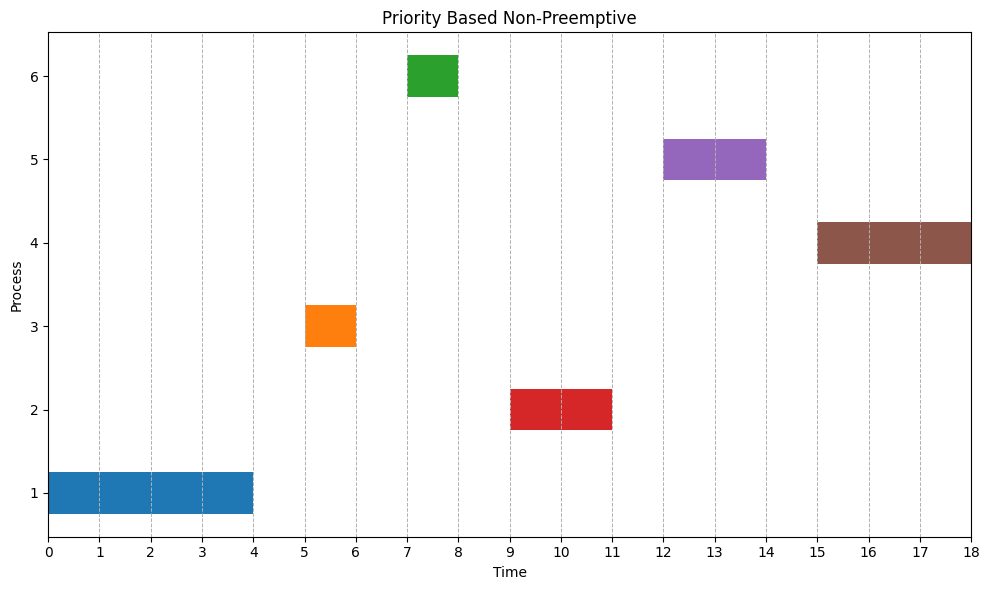

In [8]:
# Gantt chart

fig, ax = plt.subplots(figsize=(10, 6))

for task in PNONP_chart:
    y = task[0]
    start_time = task[1]
    end_time = task[2]
    ax.barh(y, end_time - start_time, left=start_time, height=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Process')
ax.set_title('Priority Based Non-Preemptive')

# x-axis range
ax.set_xlim(0, x_max)

# Add gridlines for every time slice (every unit on the x-axis)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

## ***Preemptive (P-SRTF)***

In [9]:
PP_chart = []
def PP(processes, quantum, context_switch):
    time = 0
    remaining_processes = processes.copy()
    queue = []
    completed_processes = []
    cs = False

    while len(completed_processes) < len(processes):
        
        for p in remaining_processes:
            if p.arrival_time <= time and p not in queue and p not in completed_processes:
                queue.append(p)

        if queue:
            
            oldprocess = queue[0]

            queue.sort(key=lambda x: x.arrival_time) # Third criteria
            queue.sort(key=lambda x: x.remaining_time) # Secound criteria
            queue.sort(key=lambda x: x.priority) # First criteria

            
            process = queue[0]
            
            if not cs and oldprocess !=  process:
                      time += context_switch
                      oldprocess.processed_time = 0
                      cs = False
                      #print("CS1")
            
            if cs:
                      time += context_switch / 2
                      oldprocess.processed_time = 0
                      cs = False
                      #print("CS1")
            
            if process.response_time == -1:
                process.response_time = time - process.arrival_time  # First time the process is executed
            process.remaining_time -= 1  
            process.processed_time += 1

            #print(f"process {process.pid} Excuted for 1ms.")
            #print(f"remaining_time {process.remaining_time}")
            time += 1
            #print(f"T{time} : P{process.pid} : R{process.remaining_time} : Q{len(queue)} : C{len(completed_processes)} : PT{process.processed_time}")
            PP_chart.append([process.pid, time-1, time])

            if process.remaining_time == 0:
                #print(f"process {process.pid} completed.")
                process.completion_time = time
                process.turnaround_time = process.completion_time - process.arrival_time
                process.waiting_time = process.turnaround_time - process.burst_time
                completed_processes.append(process)
                queue.remove(process)
                time += context_switch / 2
                cs = True
                #print("CS2")

            if process.processed_time % quantum == 0:
              if process.remaining_time != 0:
                 time += context_switch / 2
                 cs = True

        else:
            time += 1
            #print("D")


    return completed_processes

#### Result of algorithm

In [10]:
def PP_Result(processes, quantum, context_switch):
    completed_processes = PP(processes, quantum, context_switch)

    data = {
        'PID': [p.pid for p in completed_processes],
        'Arrival Time': [p.arrival_time for p in completed_processes],
        'Burst Time': [p.burst_time for p in completed_processes],
        'Completion Time': [p.completion_time for p in completed_processes],
        'Turnaround Time': [p.turnaround_time for p in completed_processes],
        'Waiting Time': [p.waiting_time for p in completed_processes],
        'Response Time': [p.response_time for p in completed_processes],
    }

    df = pd.DataFrame(data)

    print(f"Average_WT is: {df['Waiting Time'].mean()}")
    print(f"Average_RT is: {df['Response Time'].mean()}")
    print(f"Average_TT is: {df['Turnaround Time'].mean()}")


    return df

In [11]:
processes = [
    Process(1, 0, 4, 2),
    Process(2, 0, 2, 3),
    Process(3, 1, 1, 1),
    Process(4, 1, 3, 4),
    Process(5, 2, 2, 3),
    Process(6, 2, 1, 1)
]
PP_df = PP_Result(processes, 3, 1)
x_max = PP_df['Completion Time'].max()
y_max = PP_df['PID'].max()

Average_WT is: 7.333333333333333
Average_RT is: 6.5
Average_TT is: 9.5


In [12]:
PP_df

,PID,Arrival Time,Burst Time,Completion Time,Turnaround Time,Waiting Time,Response Time
0,3,1,1,3.0,2.0,1.0,1.0
1,6,2,1,5.0,3.0,2.0,2.0
2,1,0,4,9.0,9.0,5.0,0.0
3,2,0,2,12.0,12.0,10.0,10.0
4,5,2,2,15.0,13.0,11.0,11.0
5,4,1,3,19.0,18.0,15.0,15.0


In [13]:
def get_process_color(pid, total_processes):
    golden_ratio = (1 + 5 ** 0.5) / 2
    hue = (pid * golden_ratio) % 1
    return colorsys.hsv_to_rgb(hue, 0.8, 0.9)

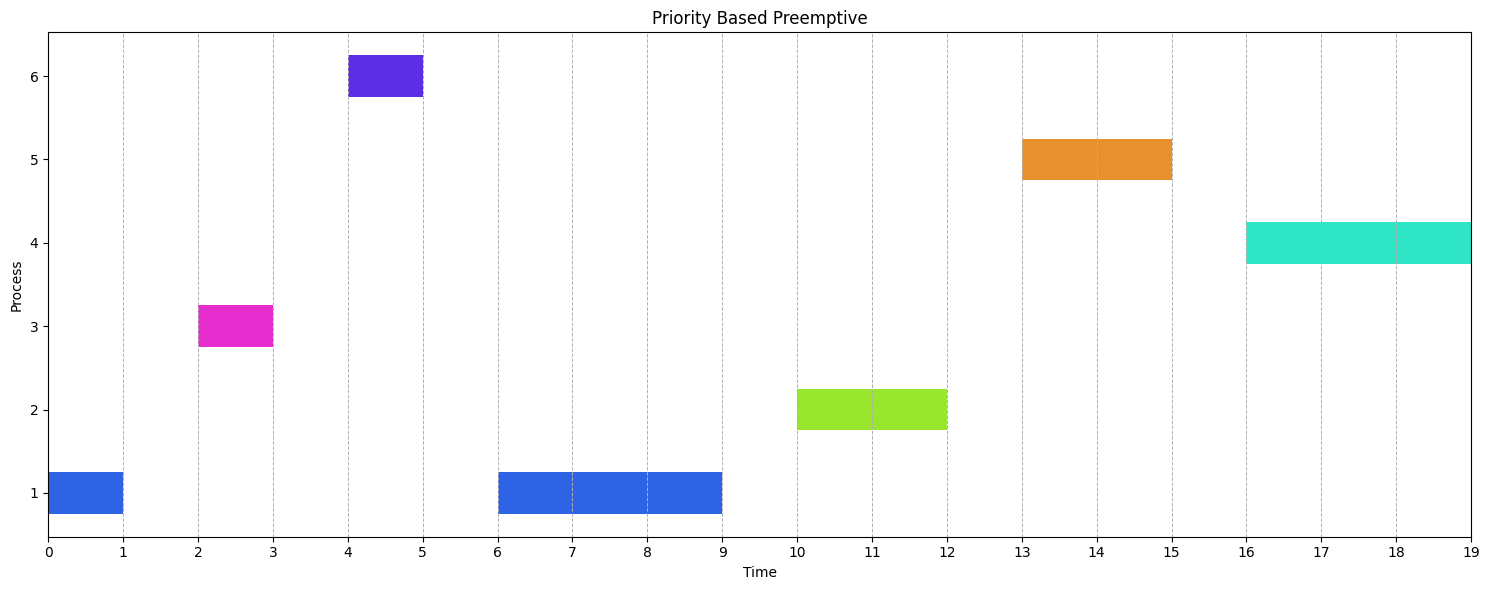

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

for task in PP_chart:
    y = task[0]
    start_time = task[1]
    end_time = task[2]
    color = get_process_color(y, y_max)
    ax.barh(y, end_time - start_time, left=start_time, height=0.5, color=color)

ax.set_xlabel('Time')
ax.set_ylabel('Process')
ax.set_title('Priority Based Preemptive')

ax.set_xlim(0, x_max)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

# MLFQ

## Algorithms

In [26]:
class MLFQ:
    def __init__(self, num_queues=3, context_switch_time=1, base_quantum_time=1):
        self.num_queues = num_queues
        self.queues = [[] for _ in range(num_queues)]
        self.mlfq_chart = []
        self.context_switch_time = context_switch_time
        self.base_quantum_time = base_quantum_time

    def run(self, processes, algorithms):
        time = 0
        remaining_processes = processes.copy()
        completed_processes = []
        current_queue_index = 0

        # until no process has been empty
        while remaining_processes or any(self.queues):

            # checking arrival time by intending time
            while remaining_processes and remaining_processes[0].arrival_time <= time:
                # first process of processes
                process = remaining_processes.pop(0)
                # that will be first queue in queues (first process of processes)
                self.queues[0].append(process)
                
            # index of first highest priority non-empty queue 
            current_queue_index = next((i for i, q in enumerate(self.queues) if q), self.num_queues - 1)

            # if index of the queue of queues was the highest (index of first highest priority non-empty queue)
            if self.queues[current_queue_index]:
                # time quantum = base_quantum_time * 2^(n-1)
                time_quantum = self.base_quantum_time * (2 ** current_queue_index)

# RR (Round Robin)
                
                if algorithms[current_queue_index] == "RR":
                    
                    self.queues[current_queue_index].sort(key=lambda p: p.arrival_time)
                    process = self.queues[current_queue_index].pop(0)
                    
                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2

                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time

                    start_time = time
                    execution_time = min(time_quantum, process.remaining_time)
                    time += execution_time
                    process.remaining_time -= execution_time

                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])

                    if process.remaining_time <= 0:
                        process.completion_time = time
                        process.turnaround_time = process.completion_time - process.arrival_time
                        process.waiting_time = process.turnaround_time - process.burst_time
                        completed_processes.append(process)
                    else:
                        # Move to lower priority queue
                        next_queue = min(current_queue_index + 1, self.num_queues - 1)
                        process.current_queue = next_queue
                        self.queues[next_queue].append(process)

                    time += self.context_switch_time / 2

# FCFS (First Come First Served)
                
                elif algorithms[current_queue_index] == "FCFS":
                    
                    self.queues[current_queue_index].sort(key=lambda p: p.arrival_time)
                    process = self.queues[current_queue_index].pop(0)

                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2

                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time

                    start_time = time
                    time += process.remaining_time
                    process.remaining_time = 0

                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])

                    process.completion_time = time
                    process.turnaround_time = process.completion_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed_processes.append(process)
                    time += self.context_switch_time / 2

# SPN (Shortest Process Next )
                
                elif algorithms[current_queue_index] == "SPN":
                    
                    self.queues[current_queue_index].sort(key=lambda x: x.remaining_time)
                    process = self.queues[current_queue_index].pop(0)

                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2

                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time

                    start_time = time
                    time += process.remaining_time
                    process.remaining_time = 0

                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])

                    process.completion_time = time
                    process.turnaround_time = process.completion_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed_processes.append(process)
                    time += self.context_switch_time / 2

# HRRN (Highest Response Ratio First)
            
                elif algorithms[current_queue_index] == "HRRN":
                    for p in self.queues[current_queue_index]:
                        p.waiting_time = time - p.arrival_time
                        p.response_ratio = (p.waiting_time + p.burst_time) / p.burst_time

                    self.queues[current_queue_index].sort(key=lambda x: x.response_ratio, reverse=True)
                    process = self.queues[current_queue_index].pop(0)

                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2

                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time

                    start_time = time
                    time += process.remaining_time
                    process.remaining_time = 0

                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])

                    process.completion_time = time
                    process.turnaround_time = process.completion_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed_processes.append(process)
                    time += self.context_switch_time / 2

# SRTF (Shortest Remaining Time First)
                
                elif algorithms[current_queue_index] == "SRTF":
                    
                    self.queues[current_queue_index].sort(key=lambda p: p.remaining_time)
                    process = self.queues[current_queue_index][0]
                
                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2
                
                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time
                
                    start_time = time
                    execution_time = min(time_quantum, process.remaining_time)
                    time += execution_time
                    process.remaining_time -= execution_time
                    process.processed_time += execution_time
                
                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])
                
                    if process.remaining_time <= 0:
                        self.queues[current_queue_index].pop(0)
                        process.completion_time = time
                        process.turnaround_time = process.completion_time - process.arrival_time
                        process.waiting_time = process.turnaround_time - process.burst_time
                        completed_processes.append(process)
                        
                    else:
                        # Move to lower priority queue if not completed
                        next_queue = min(current_queue_index + 1, self.num_queues - 1)
                        process.current_queue = next_queue
                        self.queues[next_queue].append(process)
                        self.queues[current_queue_index].pop(0)

                    time += self.context_switch_time / 2

# PP (priority preemptive) 

                elif algorithms[current_queue_index] == "PP": 
                    
                    self.queues[current_queue_index].sort(key=lambda p: p.priority)
                    process = self.queues[current_queue_index][0]
                
                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2
                
                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time
                
                    start_time = time
                    execution_time = min(time_quantum, process.remaining_time)
                    time += execution_time
                    process.remaining_time -= execution_time
                    process.processed_time += execution_time
                
                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])
                
                    if process.remaining_time <= 0:
                        self.queues[current_queue_index].pop(0)
                        process.completion_time = time
                        process.turnaround_time = process.completion_time - process.arrival_time
                        process.waiting_time = process.turnaround_time - process.burst_time
                        completed_processes.append(process)
                        
                    else:
                        # Move to lower priority queue if not completed
                        next_queue = min(current_queue_index + 1, self.num_queues - 1)
                        process.current_queue = next_queue
                        self.queues[next_queue].append(process)
                        self.queues[current_queue_index].pop(0)

                    time += self.context_switch_time / 2

# PNONP (priority none preemptive)
                
                elif algorithms[current_queue_index] == "PNONP": 
                    
                    self.queues[current_queue_index].sort(key=lambda x: (x.priority, x.arrival_time, x.remaining_time))
                    process = self.queues[current_queue_index].pop(0)

                    if len(self.mlfq_chart):
                        time += self.context_switch_time / 2

                    if process.response_time == -1:
                        process.response_time = time - process.arrival_time

                    start_time = time
                    time += process.remaining_time
                    process.remaining_time = 0

                    self.mlfq_chart.append([process.pid, start_time, time, current_queue_index])

                    process.completion_time = time
                    process.turnaround_time = process.completion_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed_processes.append(process)
                    time += self.context_switch_time / 2

            #
            else:
                time += 1

        return sorted(completed_processes, key=lambda p: p.pid)

    
#  Result df ------------------------------------------------------------------------------------------
    
    def result(self, completed_processes):
        df = pd.DataFrame({
            'PID': [p.pid for p in completed_processes],
            'Arrival Time': [p.arrival_time for p in completed_processes],
            'Burst Time': [p.burst_time for p in completed_processes],
            'Completion Time': [p.completion_time for p in completed_processes],
            'Turnaround Time': [p.turnaround_time for p in completed_processes],
            'Waiting Time': [p.waiting_time for p in completed_processes],
            'Response Time': [p.response_time for p in completed_processes],
        })

        print(f"Average Waiting Time: {df['Waiting Time'].mean():.2f}")
        print(f"Average Response Time: {df['Response Time'].mean():.2f}")
        print(f"Average Turnaround Time: {df['Turnaround Time'].mean():.2f}")

        return df


## Algorithm Example

In [29]:
# Run this cell agian, if you wanna run next function of this cell agian, after first time running
#   (brcuase the queues will be empty after run next cell, and we have to fill in the queues again)
processes = [
    Process(1, 0, 9, 2),
    Process(2, 1, 12, 3),
    Process(3, 2, 10, 1),
    Process(4, 3, 6, 4),
    Process(5, 4, 17, 3),
    Process(6, 5, 7, 1)
]

# algorithms = ["RR", "SRTF", "SRTF", "PP", "PNONP"]
# algorithms = ["SRTF", "SRTF", "RR", "PP", "PNONP"]
# algorithms = ["SRTF", "RR", "SRTF", "PP", "PNONP"]
algorithms = ["SRTF", "SPN", "SRTF", "PP", "PNONP"]

### Chart

Average Waiting Time: 19.43
Average Response Time: 6.17
Average Turnaround Time: 29.60


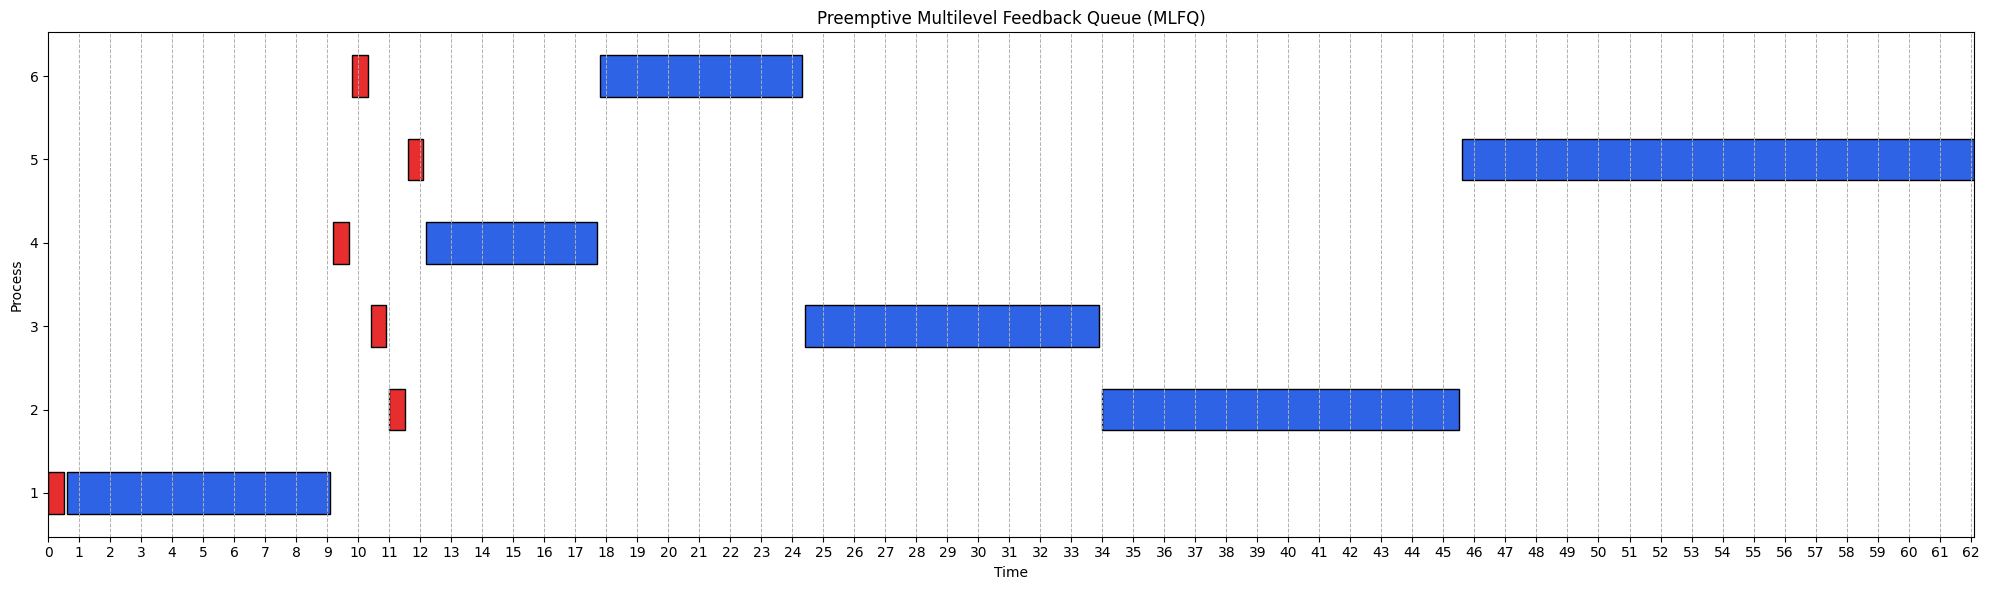

In [30]:
#  chart ------------------------------------------------------------------------------------------

def get_queue_color(queue_index, num_queues):
    return get_process_color(queue_index, num_queues)

def MLFQ_Result(processes, algorithms, num_queues=3, context_switch_time=1, base_quantum_time=1):
    mlfq = MLFQ(num_queues, context_switch_time, base_quantum_time)
    completed_processes = mlfq.run(processes, algorithms)
    df = mlfq.result(completed_processes)
    
    # Gantt Chart
    x_max = df['Completion Time'].max()
    
    fig, ax = plt.subplots(figsize=(20, 6))

    for task in mlfq.mlfq_chart:
        y = task[0]
        start_time = task[1]
        end_time = task[2]
        queue_index = task[3]
        color = get_queue_color(queue_index, mlfq.num_queues)
        ax.barh(y, end_time - start_time, left=start_time, height=0.5, color=color, edgecolor='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Process')
    ax.set_title('Preemptive Multilevel Feedback Queue (MLFQ)')

    ax.set_xlim(0, x_max)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()
    
    return df

    
mlfq_df = MLFQ_Result(processes, algorithms, num_queues=5, context_switch_time=0.1, base_quantum_time=0.5)

### Data frame

In [18]:
mlfq_df

,PID,Arrival Time,Burst Time,Completion Time,Turnaround Time,Waiting Time,Response Time
0,1,0,9,27.9,27.9,18.9,0.0
1,2,1,12,47.1,46.1,34.1,0.7
2,3,2,10,36.5,34.5,24.5,0.3
3,4,3,6,14.7,11.7,5.7,1.0
4,5,4,17,62.7,58.7,41.7,0.6
5,6,5,7,20.3,15.3,8.3,0.2


# ***Run All***

In [19]:
# Function to run all algorithms and collect results

def run_all_algorithms(processes):
    processes = [
    Process(1, 0, 9, 2),
    Process(2, 2, 12, 3),
    Process(3, 8, 7, 1),
    Process(4, 10, 11, 4),
    Process(5, 3, 8, 3),
    Process(6, 12, 2, 1),
    Process(7, 5, 11, 1),
    Process(8, 9, 1, 1),
    Process(9, 14, 22, 1),
    Process(10, 18, 12, 1),
]

    results = []
    algorithms = ['PNONP', 'PP', 'MLFQ']

    for algorithm in algorithms:
        processes_copy = [Process(p.pid, p.arrival_time, p.burst_time, p.priority) for p in processes]

        if algorithm == 'PP':
            PP(processes_copy, quantum=5 ,context_switch=2)
        elif algorithm == 'PNONP':
            PNONP(processes_copy, context_switch=2)
        elif algorithm == 'MLFQ':
            mlfq = MLFQ(num_queues=5, context_switch_time=2, base_quantum_time=5)
            processes_copy = mlfq.run(processes_copy,["RR","SRTF","SRTF","RR","SPN"])
            #processes_copy = mlfq.result(completed_processes)

        for p in processes_copy:
            results.append({
                'Algorithm': algorithm,
                'PID': p.pid,
                'Arrival Time': p.arrival_time,
                'Burst Time': p.burst_time,
                'Waiting Time': p.waiting_time,
                'Response Time': p.response_time,
                'Turnaround Time': p.turnaround_time,
                'Completion Time': p.completion_time
            })

    df = pd.DataFrame(results)
    return df

In [20]:
df_results = run_all_algorithms(processes)
df_results

,Algorithm,PID,Arrival Time,Burst Time,Waiting Time,Response Time,Turnaround Time,Completion Time
0,PNONP,1,0,9,1.0,1.0,10.0,10.0
1,PNONP,2,2,12,87.0,87.0,99.0,101.0
2,PNONP,3,8,7,11.0,11.0,18.0,26.0
3,PNONP,4,10,11,93.0,93.0,104.0,114.0
4,PNONP,5,3,8,76.0,76.0,84.0,87.0
5,PNONP,6,12,2,3.0,3.0,5.0,17.0
6,PNONP,7,5,11,23.0,23.0,34.0,39.0
7,PNONP,8,9,1,3.0,3.0,4.0,13.0
8,PNONP,9,14,22,41.0,41.0,63.0,77.0
9,PNONP,10,18,12,23.0,23.0,35.0,53.0


In [21]:
avg_df = df_results[['Algorithm', 'Waiting Time', 'Response Time', 'Turnaround Time']].groupby('Algorithm').mean()

In [22]:
# Resetting the index to make 'Algorithm' a column
avg_df.reset_index(inplace=True)

#changing the name of columns
avg_df.columns = ['Algorithm', 'AWT', 'ART', 'ATT']

avg_df

,Algorithm,AWT,ART,ATT
0,MLFQ,63.6,21.2,73.1
1,PNONP,36.1,36.1,45.6
2,PP,55.9,41.3,65.4
